In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Step 1: Read and preprocess the data
data = pd.read_csv("website.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%d/%m/%Y")

In [2]:
data.head()



,Date,Views
0,2021-06-01,7831
1,2021-06-02,7798
2,2021-06-03,7401
3,2021-06-04,7054
4,2021-06-05,7973


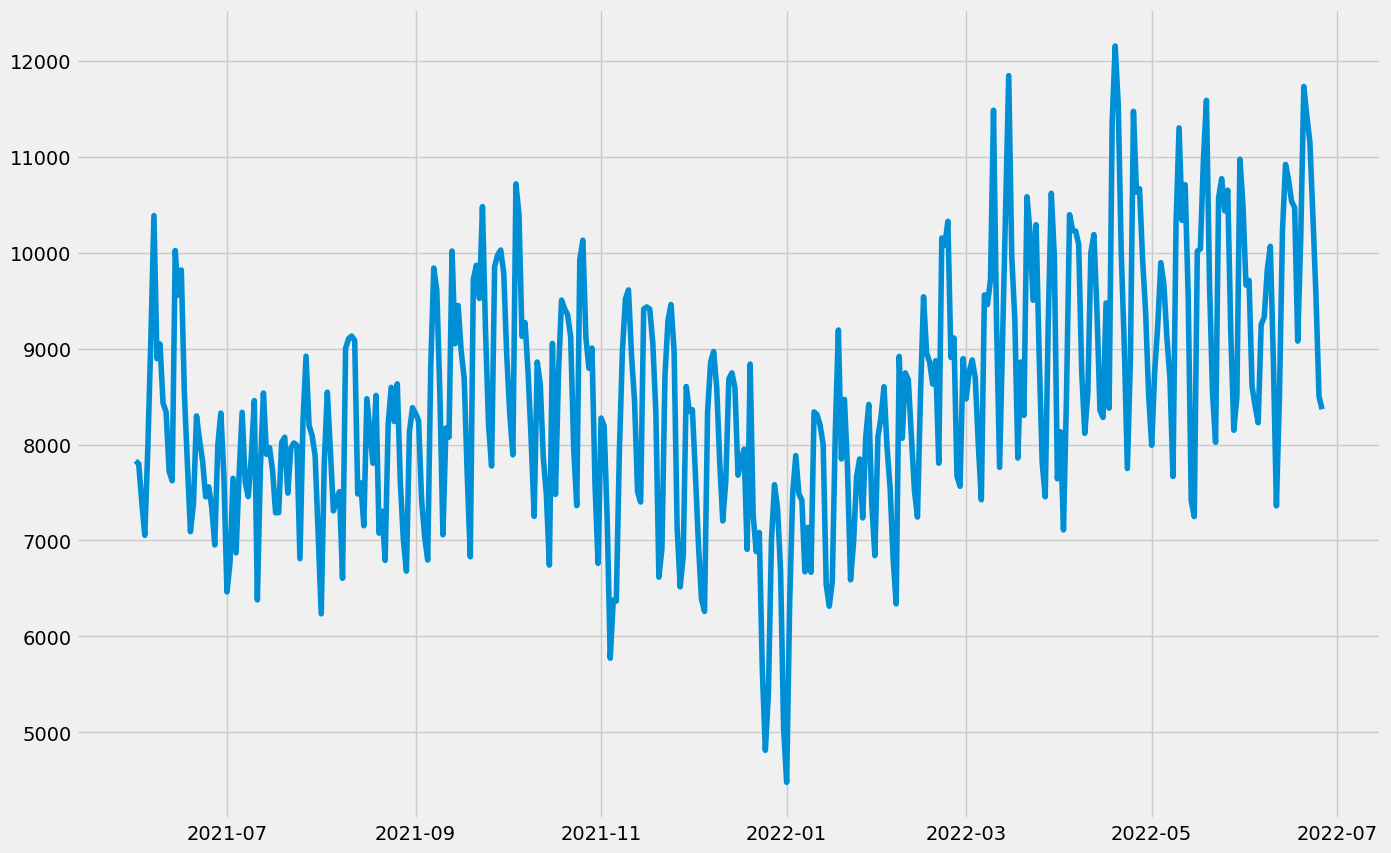

In [3]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Views"])
plt.show()

<Figure size 640x480 with 0 Axes>

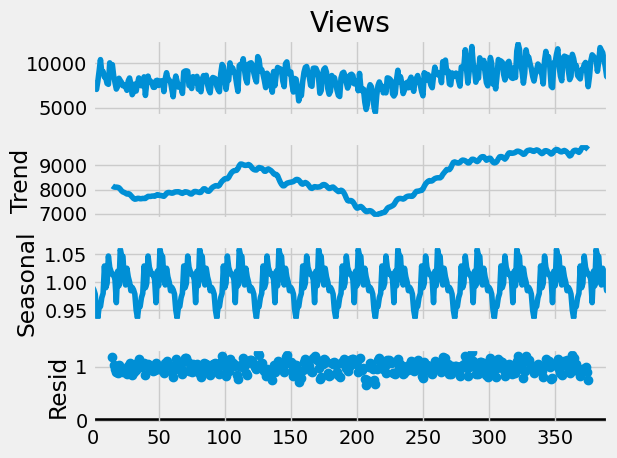

In [4]:
result = seasonal_decompose(data["Views"], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
plt.show()

In [5]:
p, d, q = 5, 1, 2
model_arima = sm.tsa.statespace.SARIMAX(data['Views'], order=(p, d, q), seasonal_order=(p, d, q, 12))
model_arima = model_arima.fit()

C:\Users\Subham.Bhuyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Subham.Bhuyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["Views"].values.reshape(-1, 1))

In [8]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

In [10]:
import numpy as np
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
time_step = 30
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(units=1)
])

C:\Users\Subham.Bhuyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model_lstm.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=1)

# Predictions
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

Epoch 1/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0398
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0206
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0238
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0201
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0188
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0185
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0190
Epoch 8/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158
Epoch 9/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0121
Epoch 10/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0107
Epoch 11/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0111
Epoch 12/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0115
Epoch 13/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113
Epoch 14/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104
Epoch 15/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2

In [14]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

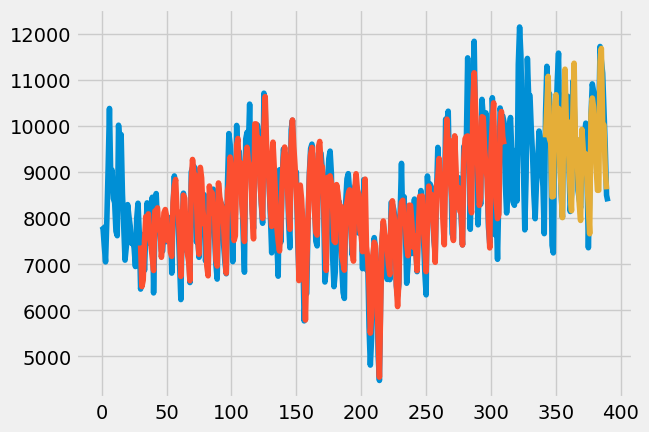

In [25]:
look_back = time_step
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_lstm)+look_back, :] = train_predict_lstm

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_lstm)+(look_back*2)+1:len(scaled_data)-1, :] = test_predict_lstm

plt.plot(scaler.inverse_transform(scaled_data))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()
  

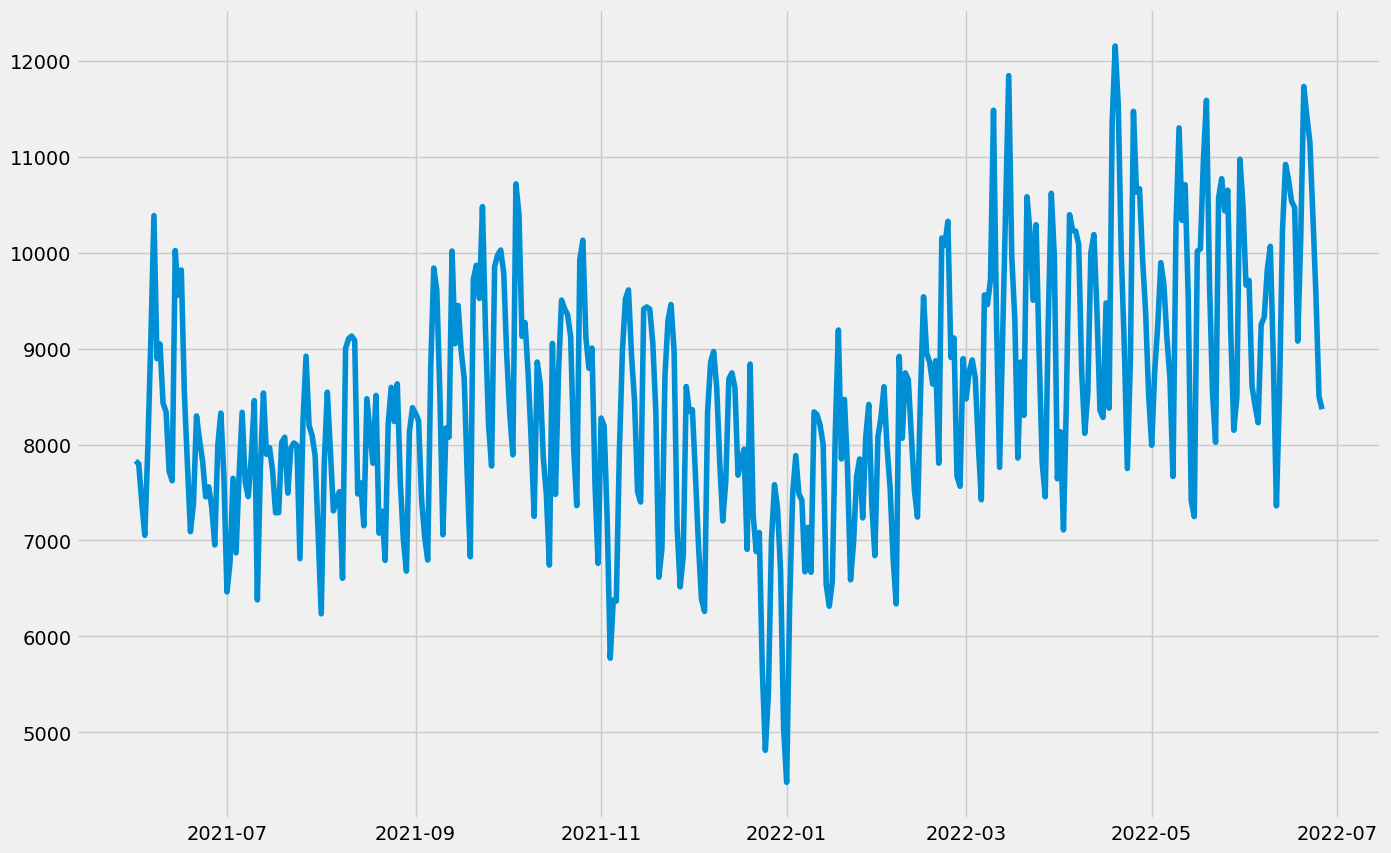

<Figure size 640x480 with 0 Axes>

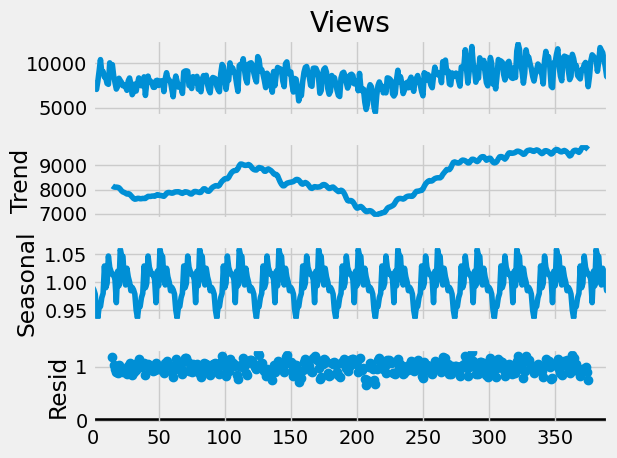

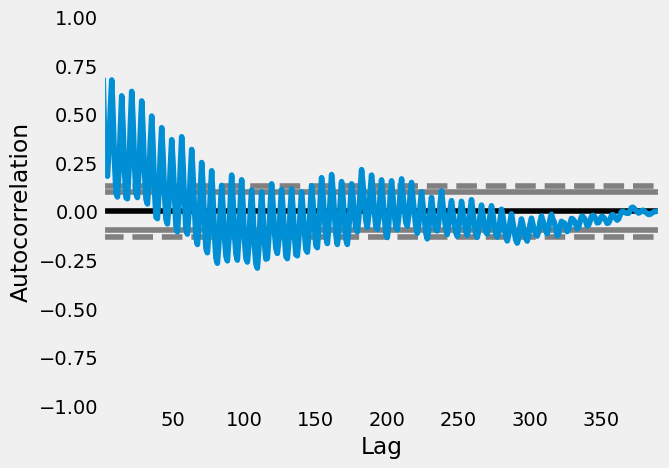

C:\Users\Subham.Bhuyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Subham.Bhuyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              Views   No. Observations:                  391
Model:             SARIMAX(5, 1, 2)x(5, 1, 2, 12)   Log Likelihood               -3099.204
Date:                            Tue, 09 Jul 2024   AIC                           6228.408
Time:                                    11:27:34   BIC                           6287.431
Sample:                                         0   HQIC                          6251.833
                                            - 391                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7901      0.128      6.195      0.000       0.540       1.040
ar.L2         -0.7805      0.136   

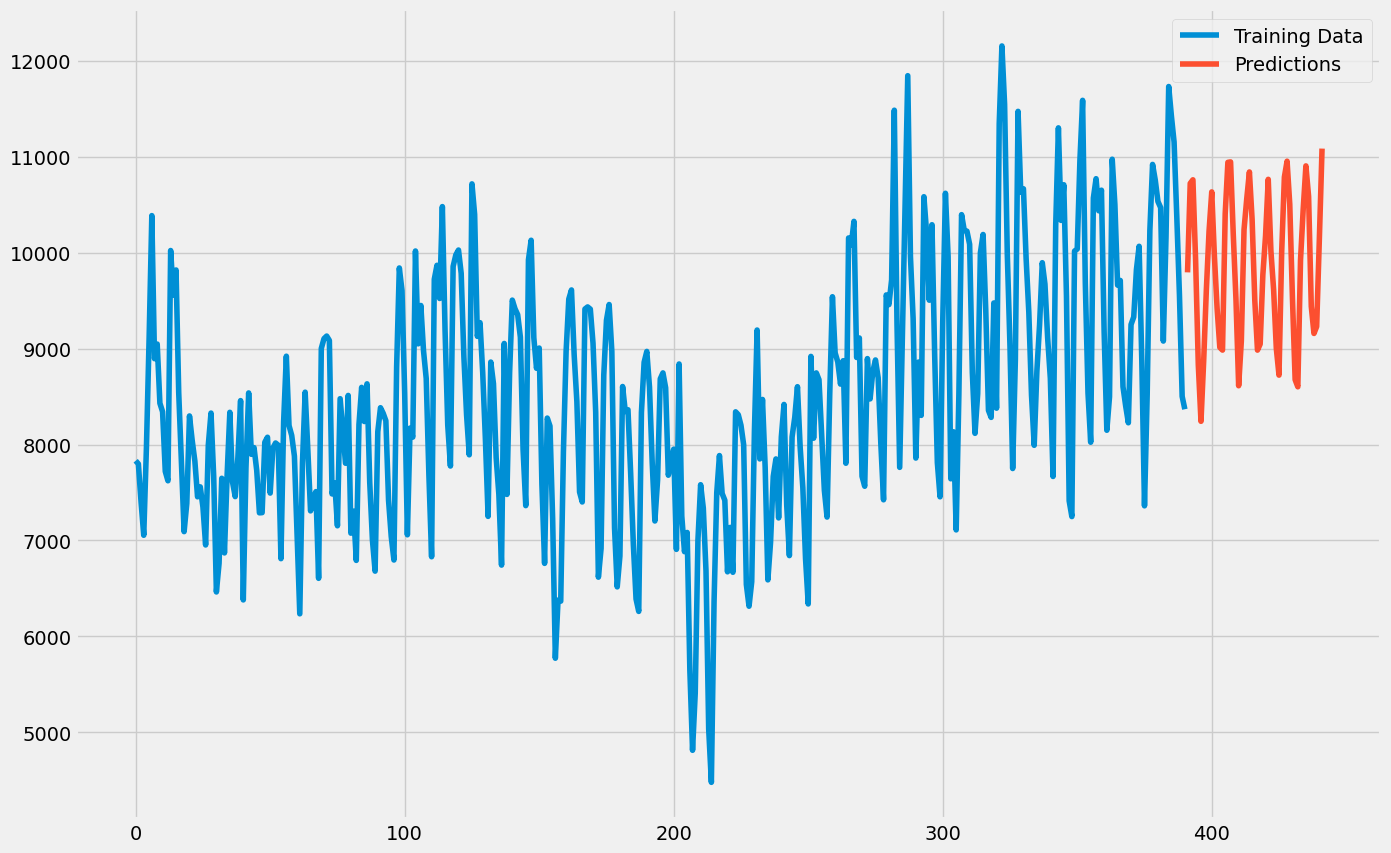